# Assignment - Probabilistic Graphical Models
### Year 2020-2021- Semester I
### CCE5225
####  Developed by - Adrian Muscat, 2020
---
Zachary Cauchi, 197999M, BSc CS, Yr I

Submit a pdf version (with the attached plagiarism form) of the final jupyter notebook (as a turn-it-in job on VLE) and the jupyter notebook itself separately (as an assignment job on VLE)

This assignment is to be attempted individually. It is essential that the work you submit and present consists only of your own work; use of copied material will be treated as plagiarism. Discussion is only permitted on general issues, and it is absolutely forbidden to discuss specific details with anyone and/or share results.



In [32]:
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

import pandas
from collections import Counter

In [17]:
infile = open('MLC_data_2020_21.pkl','rb')
data = pickle.load(infile, encoding='latin1')
infile.close()

In [18]:
# Explore dataset
print("First split is into :",data.keys(),'\n')
#
# Lets explore the development set
# This is organised into three lists
print("The three lists are",data['development'].keys(),'\n')
#
# The first element of each list corresponds to the object_labels, 
# geomteric features and output labels for the first example
# ...and so on
# Lets explore the first example
train_obj_labels = data['development']['object_labels']
train_out_labels = data['development']['output_labels']
train_geo_feat = data['development']['geometric_features']
test_obj_labels = data['test']['object_labels']
test_out_labels = data['test']['output_labels']
test_geo_feat = data['test']['geometric_features']
print("There are",len(train_obj_labels), "examples in dev set\n")
print("First example:")
print(train_obj_labels[0])
print(train_out_labels[0])
print(train_geo_feat[0])
print("\nSecond example:")
print(train_obj_labels[1])
print(train_out_labels[1])
print(train_geo_feat[1])
print("\n...")

First split is into : dict_keys(['development', 'test']) 

The three lists are dict_keys(['object_labels', 'output_labels', 'geometric_features']) 

There are 4253 examples in dev set

First example:
['2008_001130.jpg', 'tvmonitor', 'bottle']
['next_to', 'at_the_level_of', 'near']
[ 0.68888274  0.07051991  0.          0.88679245  0.39215686  0.63316053
  0.109375    1.36170213  1.14893617  1.06603774  0.58490566  9.76862745
  0.5546875  -0.30530973]

Second example:
['2008_002210.jpg', 'person_2', 'diningtable']
['behind', 'opposite', 'near']
[ 0.43984962  0.28696742  0.16        0.40206186  2.36082474  0.48306117
  0.          2.27350427  0.31623932  1.          0.66666667  1.53275109
  0.34962406 -0.33333333]

...


In [19]:
# Example 
# Learning the one-hot encoder

# read all prepositions in multilabel examples and flatten
all_preps=[]
for Y in data['development']['output_labels']:
    for y in Y:
        all_preps.append(y)

values = np.array(all_preps).reshape(len(all_preps),)
print("Shape of values", values.shape,'\n')

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("Unique labels:\n",label_encoder.classes_,'\n')

# onehot encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("Example of One-Hot Encoded:\n", onehot_encoded[0],'\n')

# single label encoding for first example
print("Consider first example\n")
b = np.array(data['development']['output_labels'][0])
b = b.reshape(len(b),1)
print("Output Labels:\n",b)
print("\nOne-Hot encoded labels:")
for i in b:
    a = label_encoder.transform(i)
    print(onehot_encoder.transform(a.reshape(-1, 1))[0])



Shape of values (9180,) 

Unique labels:
 ['above' 'against' 'along' 'around' 'at_the_level_of' 'behind' 'beyond'
 'far from' 'in' 'in_front_of' 'near' 'next_to' 'none' 'on' 'opposite'
 'outside_of' 'under'] 

Example of One-Hot Encoded:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 

Consider first example

Output Labels:
 [['next_to']
 ['at_the_level_of']
 ['near']]

One-Hot encoded labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# Section 1: Preparing the data

In [20]:
# 1.a. Computing the mean output label count per example, per dataset (development and test)
average_out_count_train = 0
average_out_count_test = 0

for row in train_out_labels:
    average_out_count_train += len(row)
for row in test_out_labels:
    average_out_count_test += len(row)

average_out_count_train /= len(train_out_labels)
average_out_count_test /= len(test_out_labels)

print('Answer to 1.a:')
print('Mean output labels per row (train set): ', average_out_count_train)
print ('Mean output labels per row (test set): ', average_out_count_test)


Answer to 1.a:
Mean output labels per row (train set):  2.1584763696214435
Mean output labels per row (test set):  2.148496240601504


Results for 1.b:
                                                  0
Label distribution in development (train) set      
next_to                                        1411
at_the_level_of                                 926
near                                           2276
behind                                         1055
opposite                                        267
on                                              359
in_front_of                                    1102
above                                           117
under                                           432
far from                                        376
against                                         593
outside_of                                       43
beyond                                           42
around                                           34
in                                               56
along                                            69
none                                           

<AxesSubplot:xlabel='Label distribution in test set'>

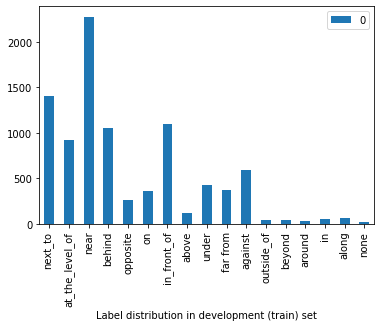

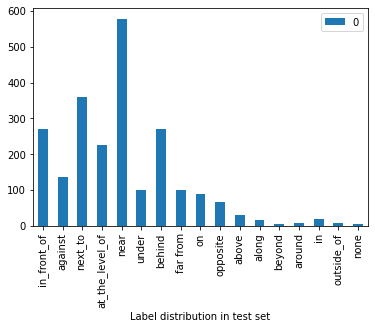

In [39]:
# 1.b. Flatten the output labels to a 1-d array, computing the distribution for both datasets

# Flatten the labels into a 1D array
flat_out_train = np.concatenate(train_out_labels)
flat_out_test = np.concatenate(test_out_labels)

# Count the numbers of each label
train_out_counts = Counter(flat_out_train)
test_out_counts = Counter(flat_out_test)

# Create dataframes from each counter object above.
train_out_counts_df = pandas.DataFrame.from_dict(train_out_counts, orient='index')
train_out_counts_df.index.name = 'Label distribution in development (train) set'
test_out_counts_df = pandas.DataFrame.from_dict(test_out_counts, orient='index')
test_out_counts_df.index.name = 'Label distribution in test set'

print("Results for 1.b:")
print(train_out_counts_df)
print(test_out_counts_df)